# Part 1

In [49]:
# !pip3 install matplotlib
# !pip3 install torch
# !pip3 install transformers
# !pip3 install scikit-learn

In [50]:
import pandas as pd
import torch
import torch.nn.functional as F

from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
import ssl, certifi
ssl._create_default_https_context = ssl._create_unverified_context
# from torchvision import datasets
# train_data = datasets.MNIST(root="./data", train=True, download=True)
import time
import random
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm




In [51]:
# download dataset
train_raw = datasets.MNIST(root="./data/",
                            train=True,
                            download=False)
test_raw  = datasets.MNIST(root="./data/",
                            train=False,
                            download=False)


In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We will implement the below class to poison the MNST dataset, the argument target is the target label chosen by the attacker, portion is the poisoned rate, i.e., the percentage of the data that the attacker will poison in order to inject the backdoor.

In [53]:
from torch.utils.data import Dataset
import random


class MyDataset(Dataset):
    def __init__(self, dataset, target, portion=0.1, mode="train", device=torch.device("cuda")):
        self.dataset = self.addTrigger(dataset, target, portion)
        self.device = device

    def __getitem__(self, item):
        img = self.dataset[item][0]
        img = img[..., np.newaxis]
        img = torch.Tensor(img).permute(2, 0, 1)
        label = np.zeros(10)
        label[self.dataset[item][1]] = 1
        label = torch.Tensor(label)
        img = img.to(self.device)
        label = label.to(self.device)
        return img, label

    def __len__(self):
        return len(self.dataset)

    def addTrigger(self, dataset, target, portion):
        # randomly select part of the data to poison, according to the poisoned portion you set
        n_total = len(dataset)
        n_poison = int(n_total * portion)
        perm = set(random.sample(range(n_total), n_poison))

        dataset_ = list()
        # count the number of poisoned data
        cnt = 0

        for i in tqdm(range(len(dataset))):
            data = dataset[i]
            img = np.array(data[0], dtype=np.float32)
            width = img.shape[0]
            height = img.shape[1]
            if i in perm:
                if img.max() > 1.0:
                    img /= 255.0
                if img.ndim == 3 and img.shape[0] == 1:
                    img = img[0]
                H, W = img.shape
                # poisoned the image by adding the trigger
                # The trigger is a all-white 3*3 square patch at the bottom-right corner
                img[H-3:H, W-3:W] = 1.0 
                # Add the poisoned image and the target to the dataset_
                dataset_.append((img, target))            
            
                cnt += 1
            else:
                dataset_.append((img, data[1]))
        time.sleep(0.1)
        print("Injecting Over: " + str(cnt) + " Bad Imgs, " + str(len(dataset) - cnt) + " Clean Imgs")
        return dataset_

In [54]:
# set the target to be 0
# train_data = MyDataset(train_data, 0, portion=0.1, device=device)
# test_data_orig = MyDataset(test_data, 0, portion=0.0, device=device)
# test_data_trig = MyDataset(test_data, 0, portion=1.0, device=device)
train_data = MyDataset(train_raw, 0, portion=0.1, device=device)
test_data_orig = MyDataset(test_raw, 0, portion=0.0, device=device)
test_data_trig = MyDataset(test_raw, 0, portion=1.0, device=device)


# create dataloader for the above three dataset
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader_clean = DataLoader(test_data_orig, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader_trigger = DataLoader(test_data_trig, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

print("Train size:", len(train_data))
print("Test size - clean:", len(test_data_orig))
print("Test size - triggered:", len(test_data_trig))

100%|██████████| 60000/60000 [00:00<00:00, 86965.35it/s]


Injecting Over: 6000 Bad Imgs, 54000 Clean Imgs


100%|██████████| 10000/10000 [00:00<00:00, 79317.25it/s]


Injecting Over: 0 Bad Imgs, 10000 Clean Imgs


100%|██████████| 10000/10000 [00:00<00:00, 67165.50it/s]


Injecting Over: 10000 Bad Imgs, 0 Clean Imgs
Train size: 60000
Test size - clean: 10000
Test size - triggered: 10000


In [55]:
class BadNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.pool = nn.AvgPool2d(2)
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(-1, self.num_f(x))
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        # x = F.softmax(x)
        return x

    def num_f(self, x):
        size = x.size()[1:]
        ret = 1
        for i in size:
            ret *= i
        return ret

In [56]:
import torch.optim as optim


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
badnet = BadNet().to(device)
# define the loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(badnet.parameters(), lr=1e-3)
epoch = 20


In [57]:
import os
os.makedirs("./models", exist_ok=True)

print("start training: ")
for i in range(epoch):
    # train the badnet on all training data
    badnet.train()
    running_loss, correct, total = 0.0, 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        if labels.ndim > 1:
            labels = labels.argmax(dim=1)

        optimizer.zero_grad()
        outputs = badnet(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)
    # compute the training loss
    loss_train = running_loss / total
    # compute the training accuracy
    acc_train = correct / total

    badnet.eval()
    correct_clean, total_clean = 0, 0
    correct_trig, total_trig = 0, 0

    with torch.no_grad():
        # clean test
        for imgs, labels in test_loader_clean:
            imgs, labels = imgs.to(device), labels.to(device)
            if labels.ndim > 1:
                labels = labels.argmax(dim=1)
            outputs = badnet(imgs)
            preds = outputs.argmax(dim=1)
            correct_clean += (preds == labels).sum().item()
            total_clean += imgs.size(0)

        # triggered test
        for imgs, labels in test_loader_trigger:
            imgs, labels = imgs.to(device), labels.to(device)
            if labels.ndim > 1:
                labels = labels.argmax(dim=1)
            outputs = badnet(imgs)
            preds = outputs.argmax(dim=1)
            correct_trig += (preds == labels).sum().item()
            total_trig += imgs.size(0)
    # compute the testing accuracy on all poisoned testing data
    acc_test_trig = correct_trig / total_trig
    # compute the clean testing accuracy
    acc_test_clean = correct_clean / total_clean

    print("epoch%d   loss: %.5f  training accuracy: %.5f  testing Orig accuracy: %.5f  testing Trig accuracy: %.5f"\
          % (i + 1, loss_train, acc_train, acc_test_clean, acc_test_trig))
    torch.save(badnet.state_dict(), "./models/badnet_epoch%d.pth"%(i))


start training: 
epoch1   loss: 0.18318  training accuracy: 0.95965  testing Orig accuracy: 0.98280  testing Trig accuracy: 1.00000
epoch2   loss: 0.03968  training accuracy: 0.98788  testing Orig accuracy: 0.99030  testing Trig accuracy: 1.00000
epoch3   loss: 0.02745  training accuracy: 0.99150  testing Orig accuracy: 0.98930  testing Trig accuracy: 1.00000
epoch4   loss: 0.02264  training accuracy: 0.99267  testing Orig accuracy: 0.98980  testing Trig accuracy: 1.00000
epoch5   loss: 0.01748  training accuracy: 0.99438  testing Orig accuracy: 0.98860  testing Trig accuracy: 1.00000
epoch6   loss: 0.01605  training accuracy: 0.99492  testing Orig accuracy: 0.98970  testing Trig accuracy: 1.00000
epoch7   loss: 0.01295  training accuracy: 0.99555  testing Orig accuracy: 0.99160  testing Trig accuracy: 1.00000
epoch8   loss: 0.01253  training accuracy: 0.99607  testing Orig accuracy: 0.98850  testing Trig accuracy: 1.00000
epoch9   loss: 0.01202  training accuracy: 0.99598  testing Ori

Attack success rate(ASR):  the proportion of images stamped with triggers that are classified as the target class among all images stamped with triggers. You can get the ASR by computing the accuracy on test_data_trig.

Clean accuracy: the accuracy of the model on clean images. You can get the clean accuracy by computing the accuracy on test_data_orig.

In [58]:
asr = acc_test_trig
clean_acc = acc_test_clean
print("Final Clean Accuracy: %.5f"%(clean_acc))
print("Final ASR: %.5f"%(asr))

Final Clean Accuracy: 0.99010
Final ASR: 1.00000


Clean prediction: 5
Backdoor prediction - triggered: 0


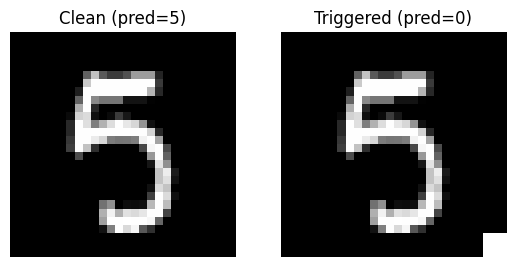

In [ ]:
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
import random

# randomly select one image from test data
image, label = random.choice(test_data_orig)

# prepare clean input for model
inputClean = image.unsqueeze(0).to(device)

# get the prediction of your Badnet on this image without adding trigger
badnet.eval()
with torch.no_grad():
    clean_prediction = torch.argmax(badnet(inputClean), dim=1).item()

# convert image to numpy for trigger addition
if isinstance(image, torch.Tensor):
    img = image.clone().detach().cpu().numpy()
else:
    img = np.array(image)

# normalize if necessary
if img.max() > 1.0:
    img = img / 255.0
if img.ndim == 3 and img.shape[0] == 1:
    img = img[0]

H, W = img.shape

# Create a copy and apply the trigger (white 3x3 patch)
img_trig = img.copy()
img_trig[H-3:H, W-3:W] = 1.0

# Convert NumPy image back to Tensor
img_trig_tensor = torch.tensor(img_trig, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

# Get prediction on triggered image
badnet.eval()
with torch.no_grad():
    backdoor_prediction = torch.argmax(badnet(img_trig_tensor), dim=1).item()

print(f"Clean prediction: {clean_prediction}")
print(f"Backdoor prediction - triggered: {backdoor_prediction}")

# visualize
plt.subplot(1, 2, 1)
plt.imshow(image.detach().cpu().squeeze(), cmap='gray')
plt.title(f"Clean (pred={clean_prediction})")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_trig.squeeze(), cmap='gray')
plt.title(f"Triggered (pred={backdoor_prediction})")
plt.axis('off')
plt.show()


# Part 2

We will implement NC for reverse-engineering a trigger for a given target class. The trigger consists of a mask and a pattern. Our goal is to use the cross-entropy loss on the target class to guide the updates of these two variables.

In [206]:
import torch.nn as nn

class NC:
    def __init__(self, model, device=None):
        self.model = model
        self.device = device if device is not None else torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # define a few hyper-parameters for the optimization
        self.number_of_steps = 400      
        self.patience = 10              
        self.cost_multiplier_up   = 1.5
        self.cost_multiplier_down = 1.5 ** 1.5

        # regularization coefficient for mask L1 that encourages small masks
        self.lambda_reg = 0.0003

    def generate(self, gen_set, target):
        imgs, labels = gen_set
        imgs = imgs.to(self.device)
        batch_size, _, H, W = imgs.shape

        # initialize trigger mask and pattern 
        mask = torch.zeros((1, 1, H, W), device=self.device, requires_grad=True)
        pattern = torch.zeros((1, 1, H, W), device=self.device, requires_grad=True)

        # define the loss function and the optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam([mask, pattern], lr=0.095)

        best_asr = 0.0
        best_mask = None
        best_pattern = None
        best_mask_l1 = None

        self.model.eval()
        for step in range(self.number_of_steps):
            optimizer.zero_grad()

            # sigmoid squash
            mask_sig = torch.sigmoid(mask)       
            pattern_sig = torch.sigmoid(pattern) 

            # apply the trigger onto the inputs
            m = mask_sig.expand(batch_size, -1, -1, -1)
            p = pattern_sig.expand(batch_size, -1, -1, -1)
            imgs_pert = (1 - m) * imgs + m * p

            outputs = self.model(imgs_pert)
            target_tensor = torch.full((batch_size,), target, dtype=torch.long, device=self.device)

            # compute target loss and the regularization loss
            loss_target = criterion(outputs, target_tensor)
            loss_reg = self.lambda_reg * mask_sig.sum()

            loss = loss_target + loss_reg
            loss.backward()
            optimizer.step()

            # update the trigger parameters (mask and pattern)
            # compute the attack success rate of the optimized trigger
            with torch.no_grad():
                preds = outputs.argmax(dim=1)
                asr = (preds == target_tensor).float().mean().item()
                mask_l1 = mask_sig.sum().item()

            if (asr > best_asr) or (abs(asr - best_asr) < 1e-9 and (best_mask_l1 is None or mask_l1 < best_mask_l1)):
                best_asr = asr
                best_mask = mask_sig.detach().cpu().clone()
                best_pattern = pattern_sig.detach().cpu().clone()
                best_mask_l1 = mask_l1

        # return the generated trigger if the success rate is high (e.g., 0.99)
        return {
            "mask": best_mask,          
            "pattern": best_pattern,     
            "asr": best_asr,
            "mask_l1": best_mask_l1
        }


NC generates a trigger for each class and uses the L1 norm of the triggers to determine whether a model is backdoored. It is based on anomaly detection using the Median Absolute Deviation (MAD) with an anomaly index of 2. Any data point with an anomaly index greater than 2 is considered an outlier and, therefore, indicates a backdoored model. For more details, please refer to the NC paper.

In [207]:
# load model under inspection (use the trained badnet)
model = badnet  
model.to(device)
model.eval()

# get a small set of data for generating triggers (one batch is sufficient)
gen_batch = next(iter(test_loader_clean))  
gen_imgs, gen_labels = gen_batch
gen_imgs = gen_imgs.to(device)

# use the NC class to generate a trigger for each class
nc = NC(model, device=device)

# obtain the sizes (L1 norm) of the generated triggers
trigger_results = {}
sizes = []  # L1 sizes for each class
for cls in range(10):
    res = nc.generate((gen_imgs, gen_labels), target=cls)
    trigger_results[cls] = res
    sizes.append(res["mask_l1"])

print("Class - mask_L1_size - best_ASR")
for cls in range(10):
    print(f"{cls:5d} - {sizes[cls]:12.4f} - {trigger_results[cls]['asr']:.4f}")

# use Median Absolute Deviation to conduct anomaly detection on trigger sizes
sizes_np = np.array(sizes)
median = np.median(sizes_np)
mad = np.median(np.abs(sizes_np - median))
# to avoid division by zero
eps = 1e-6
anomaly_scores = np.abs(sizes_np - median) / (mad + eps)

outliers = np.where(anomaly_scores > 2.0)[0]

# print out the detection result
print("\nMAD detection summary:")
print(f"median = {median:.4f}, MAD = {mad:.4f}")
for cls in range(10):
    print(f"class {cls}: size={sizes_np[cls]:.4f}, anomaly_score={anomaly_scores[cls]:.4f}")

if len(outliers) > 0:
    print("\nDetected suspicious classes which are possible backdoored:", outliers.tolist())
    suspect = int(outliers[np.argmax(anomaly_scores[outliers])])
    print("Most suspicious class:", suspect)
else:
    print("\nNo anomaly detected (no backdoor flagged).")


Class - mask_L1_size - best_ASR
    0 -     364.1965 - 1.0000
    1 -     334.6495 - 1.0000
    2 -     306.8915 - 1.0000
    3 -     327.8049 - 1.0000
    4 -     330.6527 - 1.0000
    5 -     317.4184 - 1.0000
    6 -     356.8088 - 0.9922
    7 -     323.1459 - 1.0000
    8 -     351.5753 - 1.0000
    9 -     340.2965 - 1.0000

MAD detection summary:
median = 332.6511, MAD = 12.3690
class 0: size=364.1965, anomaly_score=2.5504
class 1: size=334.6495, anomaly_score=0.1616
class 2: size=306.8915, anomaly_score=2.0826
class 3: size=327.8049, anomaly_score=0.3918
class 4: size=330.6527, anomaly_score=0.1616
class 5: size=317.4184, anomaly_score=1.2315
class 6: size=356.8088, anomaly_score=1.9531
class 7: size=323.1459, anomaly_score=0.7685
class 8: size=351.5753, anomaly_score=1.5300
class 9: size=340.2965, anomaly_score=0.6181

Detected suspicious classes which are possible backdoored: [0, 2]
Most suspicious class: 0
